Importes

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn

In [2]:
import pandas as pd

df = pd.read_csv("bank-additional-full.csv", sep=';')
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.info()
df.describe()
df.isnull().sum()
df['y'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,count
y,
no,36548
yes,4640


In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

X = df.drop('y', axis=1)
y = df['y'].map({'yes':1, 'no':0})

categorical = X.select_dtypes(include='object').columns
numeric = X.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numeric)
])

X_processed = preprocessor.fit_transform(X)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42, stratify=y)


In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

print("Varianza explicada:", pca.explained_variance_ratio_)


Varianza explicada: [0.26303446 0.09167594]


In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

df['cluster'] = clusters
df[['cluster', 'y']].groupby(['cluster','y']).size()


cluster  y  
0        no      3407
         yes      200
1        no     10228
         yes     3303
2        no     22913
         yes     1137
dtype: int64

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train, y_train)

pred_lr = log_reg.predict(X_test)
print(classification_report(y_test, pred_lr))


              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10965
           1       0.67      0.42      0.52      1392

    accuracy                           0.91     12357
   macro avg       0.80      0.70      0.74     12357
weighted avg       0.90      0.91      0.90     12357



In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf))


              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10965
           1       0.69      0.46      0.55      1392

    accuracy                           0.92     12357
   macro avg       0.81      0.72      0.75     12357
weighted avg       0.91      0.92      0.91     12357



In [10]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators":[100,200],
    "max_depth":[5,10,None]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor score:", grid.best_score_)


Mejores parámetros: {'max_depth': None, 'n_estimators': 100}
Mejor score: 0.5155008608288444


In [11]:
subset = df[['age','duration','y']]

subset.to_csv("subset_knn.csv", index=False)
subset.head()


,age,duration,y
0,56,261,no
1,57,149,no
2,37,226,no
3,40,151,no
4,56,307,no


Parte en C

In [13]:
%%bash
sudo apt-get update
sudo apt-get install gcc

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Pa

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [20]:
%%bash
cat << 'EOF' > programa.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <string.h>

#define MAX_ROWS 5000
#define K 5

typedef struct {
    float age;
    float duration;
    int label;
} DataPoint;

float distance(DataPoint a, DataPoint b) {
    return sqrtf(
        (a.age - b.age) * (a.age - b.age) +
        (a.duration - b.duration) * (a.duration - b.duration)
    );
}

int main() {
    FILE *file = fopen("subset_knn.csv", "r");
    if (!file) {
        printf("Error abriendo archivo.\n");
        return 1;
    }

    DataPoint data[MAX_ROWS];
    int n = 0;

    char line[256];
    fgets(line, sizeof(line), file);

    while (fgets(line, sizeof(line), file) && n < MAX_ROWS) {
        sscanf(line, "%f,%f,%d",
               &data[n].age,
               &data[n].duration,
               &data[n].label);
        n++;
    }
    fclose(file);

    printf("Datos cargados: %d filas\n", n);

    int split = (int)(n * 0.8);
    int correct = 0;
    int total = n - split;

    for (int i = split; i < n; i++) {

        float dists[MAX_ROWS];
        int labels[MAX_ROWS];

        for (int j = 0; j < split; j++) {
            dists[j] = distance(data[i], data[j]);
            labels[j] = data[j].label;
        }

        for (int a = 0; a < K; a++) {
            for (int b = a + 1; b < split; b++) {
                if (dists[b] < dists[a]) {
                    float tmpd = dists[a];
                    dists[a] = dists[b];
                    dists[b] = tmpd;

                    int tmpl = labels[a];
                    labels[a] = labels[b];
                    labels[b] = tmpl;
                }
            }
        }

        int votes_yes = 0, votes_no = 0;
        for (int k = 0; k < K; k++) {
            if (labels[k] == 1) votes_yes++;
            else votes_no++;
        }

        int prediction = (votes_yes > votes_no ? 1 : 0);

        if (prediction == data[i].label)
            correct++;
    }

    float accuracy = (correct * 100.0f) / total;

    printf("Accuracy KNN: %.2f%%\n", accuracy);

    return 0;
}
EOF

In [22]:
%%bash
gcc programa.c -o programa -lm
./programa

Datos cargados: 5000 filas
Accuracy KNN: 77.80%


Creacion de graficos

In [24]:
!pip install seaborn scikit-learn pandas matplotlib umap-learn

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [26]:
import pandas as pd

df = pd.read_csv("bank-additional-full.csv", sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [27]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [28]:
df.describe()


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [29]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df['y'].value_counts()

,count
y,
0,36548
1,4640


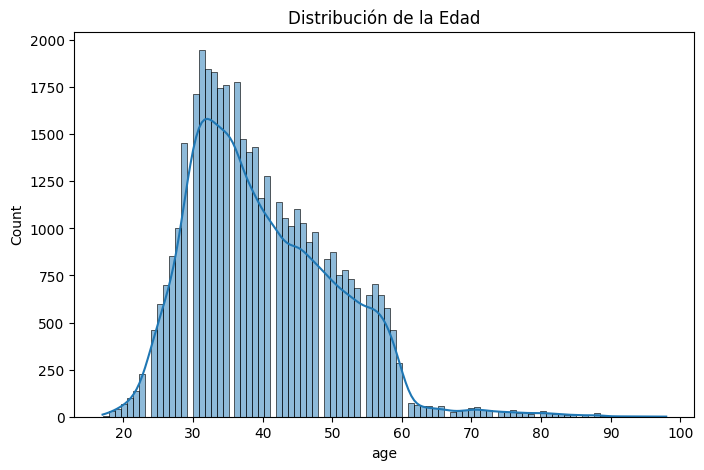

In [30]:
plt.figure(figsize=(8,5))
sns.histplot(df['age'], kde=True)
plt.title("Distribución de la Edad")
plt.savefig("hist_age.png")
plt.show()


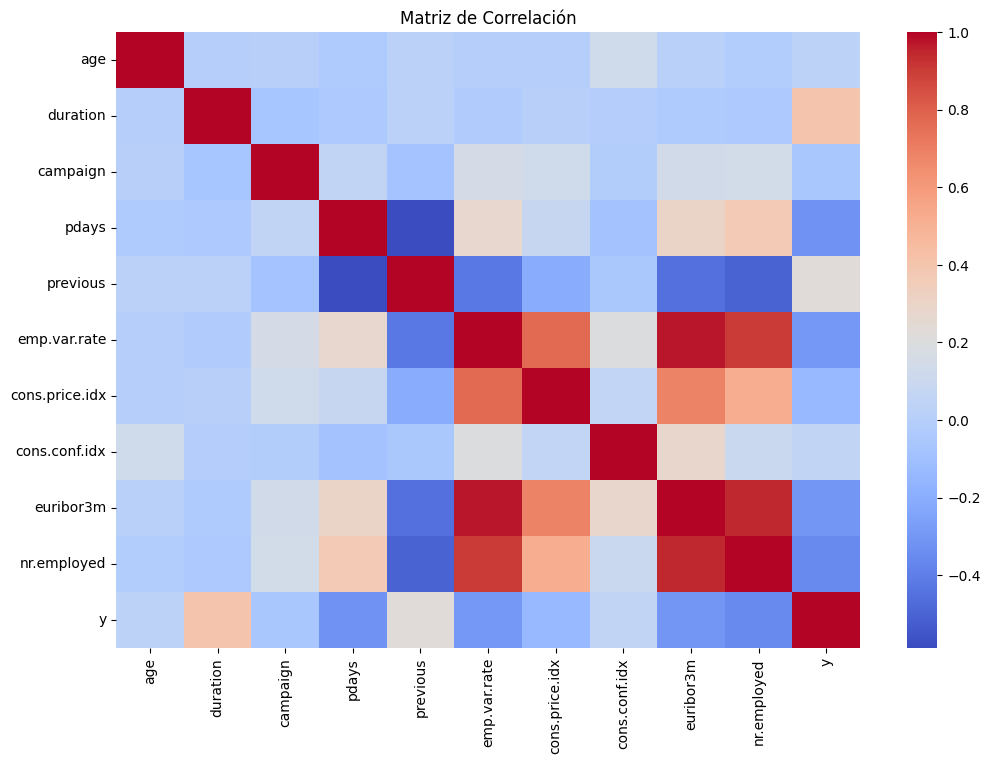

In [31]:
num_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(12,8))
sns.heatmap(num_df.corr(), cmap='coolwarm', annot=False)
plt.title("Matriz de Correlación")
plt.savefig("heatmap_corr.png")
plt.show()


In [32]:
X = df.drop(columns=['y'])
y = df['y']


In [33]:
X = pd.get_dummies(X, drop_first=True)
X.shape


(41188, 53)

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42, stratify=y
)


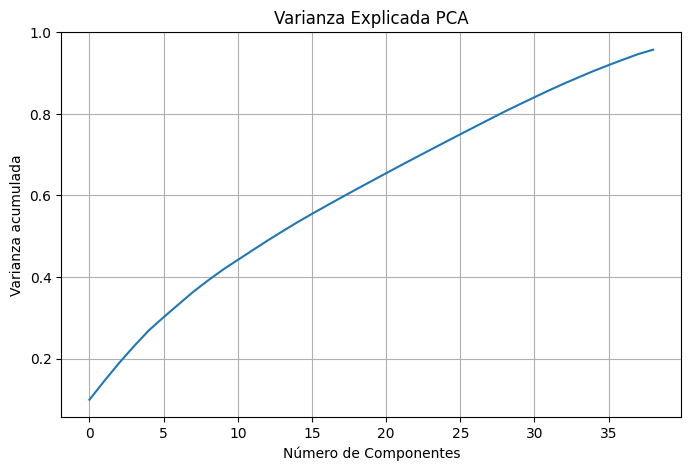

In [36]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza acumulada")
plt.title("Varianza Explicada PCA")
plt.grid(True)
plt.savefig("pca_variance.png")
plt.show()


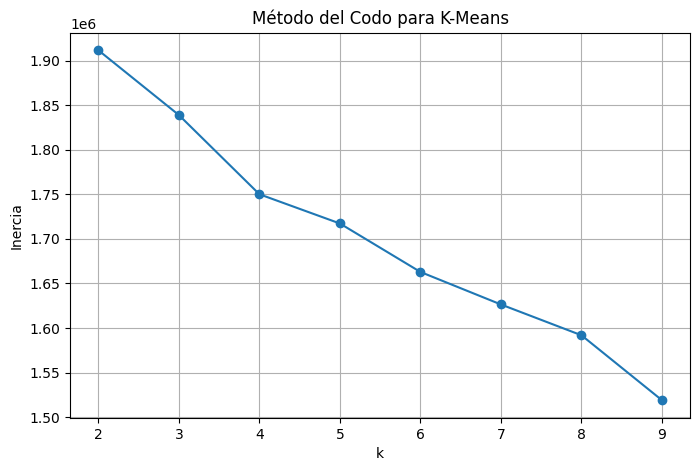

In [37]:
inertia = []
K_range = range(2,10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.title("Método del Codo para K-Means")
plt.xlabel("k")
plt.ylabel("Inercia")
plt.grid(True)
plt.savefig("kmeans_elbow.png")
plt.show()


In [38]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)


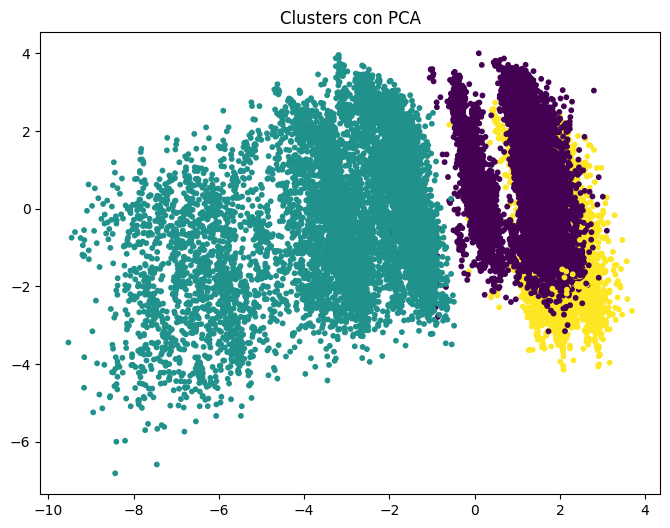

In [39]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', s=10)
plt.title("Clusters con PCA")
plt.savefig("clusters_pca.png")
plt.show()


In [40]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("LOGISTIC REGRESSION")
print(classification_report(y_test, y_pred_log))


LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10965
           1       0.68      0.42      0.52      1392

    accuracy                           0.91     12357
   macro avg       0.80      0.70      0.74     12357
weighted avg       0.90      0.91      0.90     12357



In [41]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("RANDOM FOREST")
print(classification_report(y_test, y_pred_rf))


RANDOM FOREST
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10965
           1       0.68      0.49      0.57      1392

    accuracy                           0.92     12357
   macro avg       0.81      0.73      0.76     12357
weighted avg       0.91      0.92      0.91     12357



In [42]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM")
print(classification_report(y_test, y_pred_svm))


SVM
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10965
           1       0.67      0.32      0.43      1392

    accuracy                           0.91     12357
   macro avg       0.80      0.65      0.69     12357
weighted avg       0.89      0.91      0.89     12357



<Figure size 500x400 with 0 Axes>

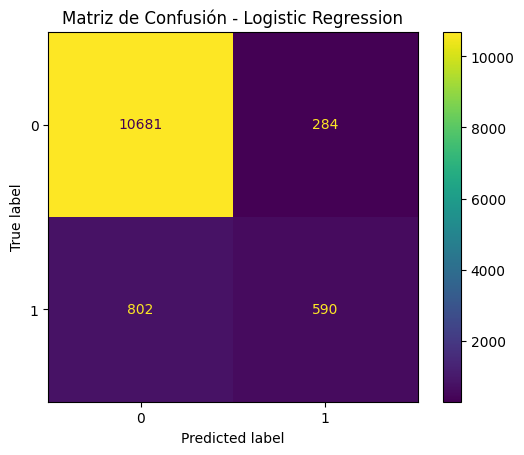

<Figure size 500x400 with 0 Axes>

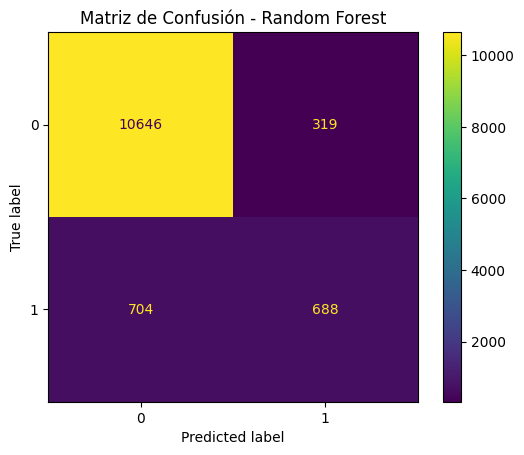

<Figure size 500x400 with 0 Axes>

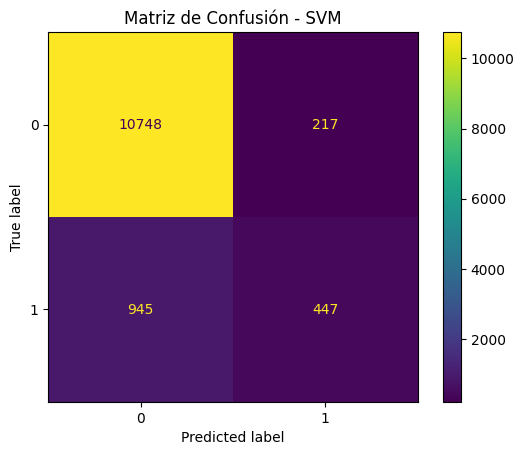

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

models = {
    "Logistic Regression" : y_pred_log,
    "Random Forest" : y_pred_rf,
    "SVM" : y_pred_svm
}

for name, preds in models.items():
    plt.figure(figsize=(5,4))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.title(f"Matriz de Confusión - {name}")
    plt.savefig(f"cm_{name.replace(' ', '_')}.png")
    plt.show()


In [44]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_i, test_i in kfold.split(X_scaled):
    Xtr, Xte = X_scaled[train_i], X_scaled[test_i]
    ytr, yte = y.iloc[train_i], y.iloc[test_i]

    model = RandomForestClassifier(n_estimators=200)
    model.fit(Xtr, ytr)
    scores.append(model.score(Xte, yte))

print("Cross-Validation Scores:", scores)
print("Promedio:", np.mean(scores))


Cross-Validation Scores: [0.9127215343529983, 0.9129643117261471, 0.9115076474872542, 0.9165958480029137, 0.9141677795313828]
Promedio: 0.9135914242201393


In [45]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

print("Mejores hiperparámetros:")
print(grid.best_params_)


Mejores hiperparámetros:
{'max_depth': 20, 'n_estimators': 300}


In [46]:
subset = df[['age', 'duration', 'y']].sample(5000, random_state=42)
subset.to_csv("subset_knn.csv", index=False)
subset.head()


,age,duration,y
32884,57,371,0
3169,55,285,0
32206,33,52,0
9403,36,355,0
14020,27,189,0


In [47]:
print("Accuracy Logistic Regression:", accuracy_score(y_test, y_pred_log))
print("Accuracy Random Forest:", accuracy_score(y_test, y_pred_rf))
print("Accuracy SVM:", accuracy_score(y_test, y_pred_svm))


Accuracy Logistic Regression: 0.9121145909201263
Accuracy Random Forest: 0.9172129157562515
Accuracy SVM: 0.905964230800356
